In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.io import loadmat
import copy

In [2]:
# load data
matfile = loadmat('/sampleEEGdata')
EEG = matfile['EEG'][0][0]
EEG_data = EEG['data'] # data shape is (64,640,99)
times = EEG['times'].squeeze()
fs = EEG['srate']
num_ch = EEG['nbchan'][0][0]

In [3]:
# perform PCA for the first stage of compression and source separation

# copy EEG data
data = copy.deepcopy(EEG_data)

# construct empty covariance matrix
cov = np.zeros((num_ch, num_ch))

# loop through each trial and mean center data by its features (channels)
for trial in range(int(data.shape[2])):
  for ch in range(int(data.shape[0])):
    data[ch,:,trial] -= np.mean(data[ch,:,trial])
  # take cov matrix of each trial and add to cov variable
  cov += np.cov(data[:,:,trial])

# average the covariances across all trials
cov /= data.shape[2]

# obtain eigenvalues and eigenvectors
eigs,evecs = np.linalg.eig(cov)
sort = np.argsort(eigs)[::-1]
eigs = eigs[sort]
evecs = evecs[:,sort]

# determine percent variance of eigenvalues
var = (100*eigs)/np.sum(eigs)

# retain the components that represent greater than 0.1% of variance
comp2keep = sum(var > 0.1)

# project trial data onto principal components
pca_data = np.zeros((comp2keep,int(data.shape[1]),int(data.shape[2])))

for trial in range(int(data.shape[2])):
  pca_data[:,:,trial] = evecs[:,:comp2keep].T@data[:,:,trial]

In [4]:
# perform GED for the second stage of compression and source separation

# create a narrowband filter with a peak of 11Hz and a FWHM of 4Hz
filt_coef = signal.firwin(numtaps=171,cutoff=[9,13],fs=fs,pass_zero=False)
filt_data = np.zeros_like(pca_data)

# apply filter to pca_data
for trial in range(int(pca_data.shape[2])):
  for ch in range(int(pca_data.shape[0])):
    filt_data[ch,:,trial] = np.convolve(pca_data[ch,:,trial], filt_coef, mode='same')

# obtain S and R covariance matrices - filtered and pca data, respectively.
covS = np.zeros((filt_data.shape[0],filt_data.shape[0]))
covR = np.zeros((pca_data.shape[0],pca_data.shape[0]))

for trial in range(int(pca_data.shape[2])):
  for ch in range(int(pca_data.shape[0])):
    # mean-center data
    filt_data[ch,:,trial] -= np.mean(filt_data[ch,:,trial])
    pca_data[ch,:,trial] -= np.mean(pca_data[ch,:,trial])

  covS += np.cov(filt_data[:,:,trial])
  covR += np.cov(pca_data[:,:,trial])

covS /= filt_data.shape[2]
covR /= pca_data.shape[2]

# obtain generalized eigenvalues and eigenvectors
eigsged,evecsged = scipy.linalg.eigh(covS,covR)
srt = np.argsort(eigsged)[::-1]
eigsged = eigsged[srt]
evecsged = evecsged[:,srt]

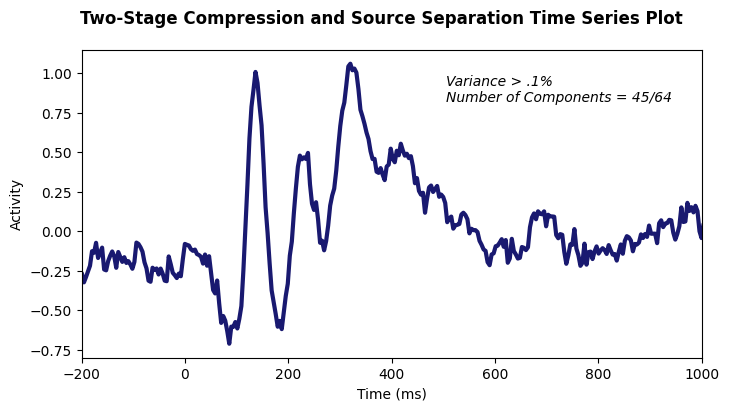

In [5]:
# produce GED component time series
ged_data = np.zeros((1,data.shape[1],data.shape[2]))

for trial in range(int(ged_data.shape[2])):
  # project unfiltered PCA data onto GED component
  ged_data[:,:,trial] = evecsged[:,:1].T@pca_data[:,:,trial]

# take the average across all trials
mean_ged = np.mean(ged_data,axis=2).squeeze()

# plot the time series data
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(times,mean_ged*(-1), lw=3, color='midnightblue')
fig.suptitle('Two-Stage Compression and Source Separation Time Series Plot',
             fontweight='bold')
ax.set(xlabel='Time (ms)', ylabel='Activity', xlim=[-200,1000])
fig.text(.58,0.75,
         'Variance > .1% \nNumber of Components = 45/64',
         style='italic')
plt.show()